# Где дешевле жить? Предсказание цен в Airbnb - учимся генерировать признаки и интерпретировать результаты модели

In [198]:
import pandas as pd
import numpy as np
from sklearn import datasets
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import math
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor


%matplotlib inline
# IPython/Jupyter magic для вывода графиков Matplotlib прямо в ячейках ноутбука (вместо отдельных окон). 
np.random.seed(11)

df = pd.read_csv('archive/AB_NYC_2019.csv')
df = df.drop(columns=['id', 'name', 'host_id', 'host_name', 'last_review'])
df.head()

# Обработать категориальные признаки room_type
# Избавиться от выбросов в price? minimum_hights? 

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [199]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


## Убираем пустые значения в данных. Логарифмируем price для того чтобы сгладить выбросы.

In [200]:
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
df.isnull().sum()

# фильтруем цену
df = df[(df["price"] > 0) & (df["price"] <= 500)]
df['log_price'] = np.log1p(df['price'])

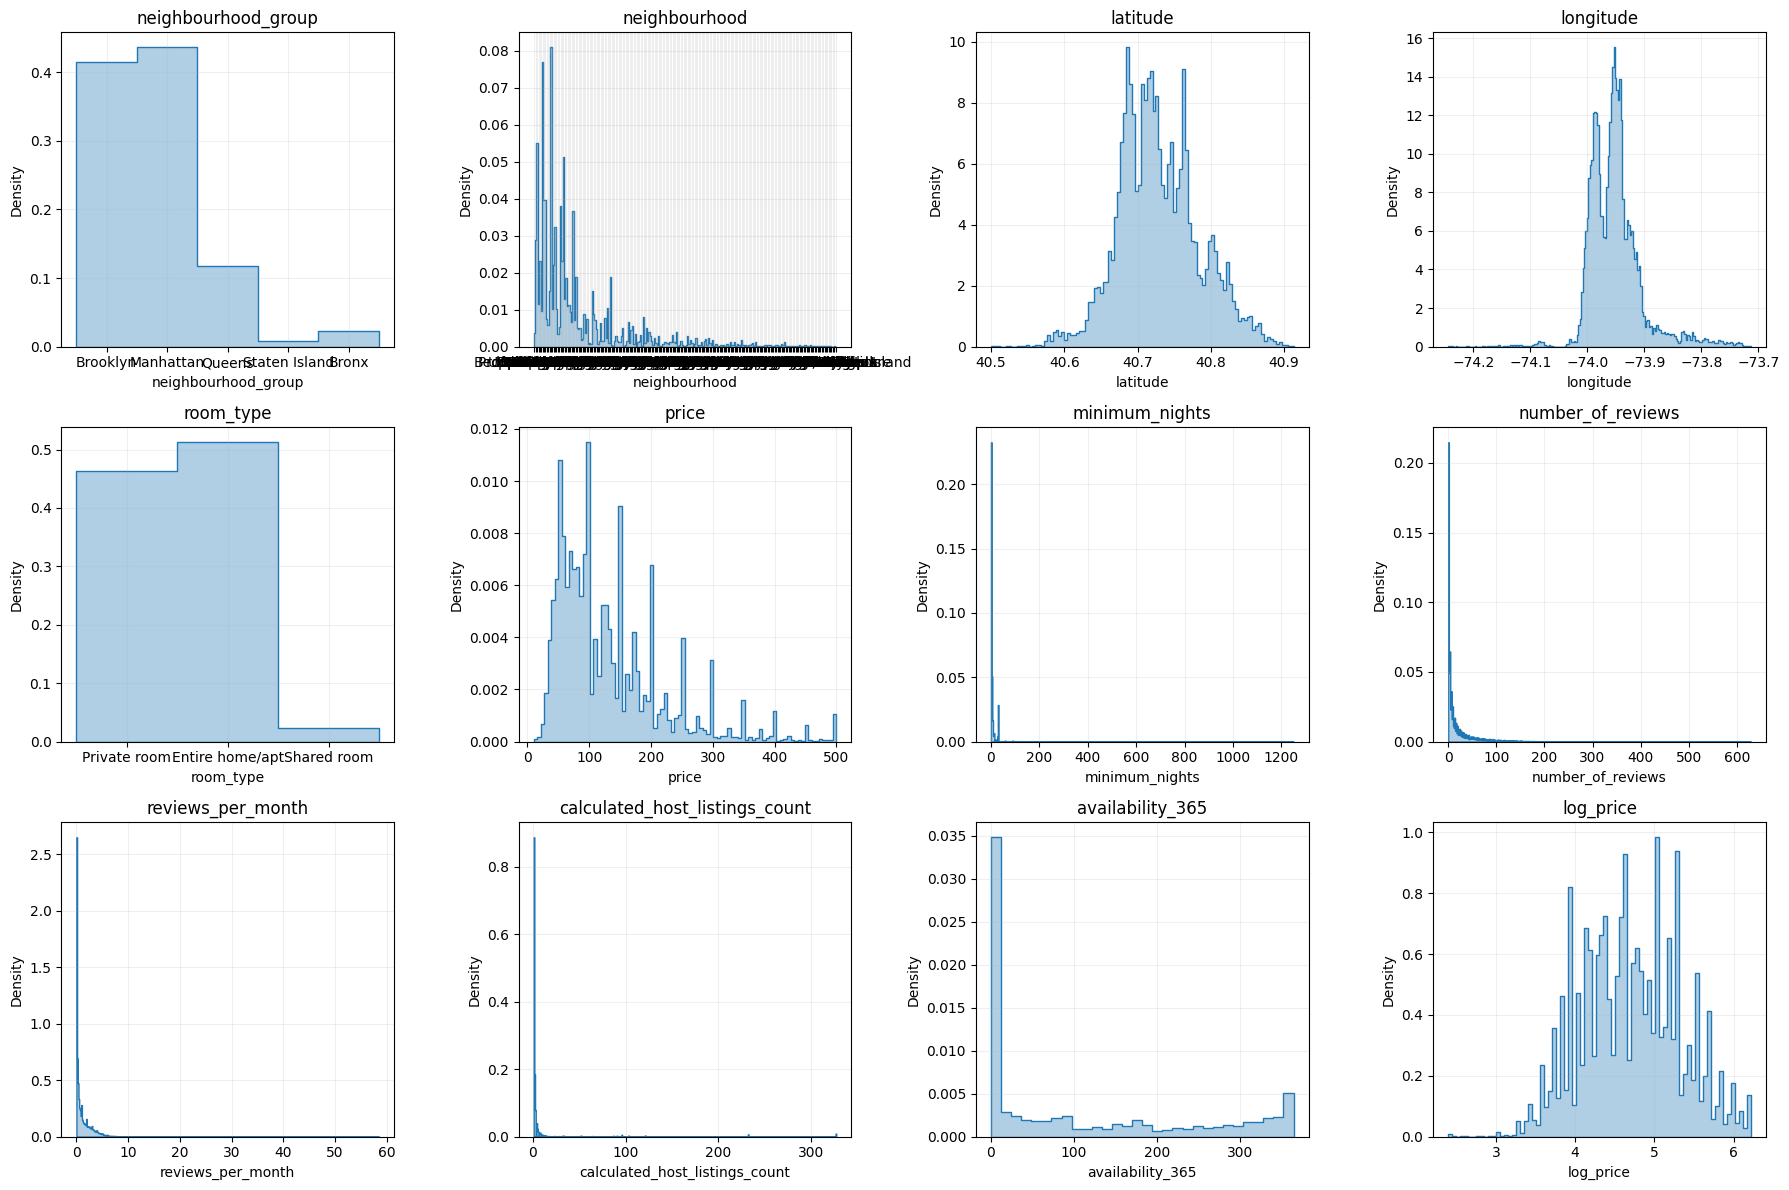

In [201]:

def print_plots (df):
    target = "price"
    feature_cols = df.columns
    n_cols = 4
    n_rows = math.ceil(len(feature_cols) / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharey=False)
    axes = axes.ravel()

    for ax, col in zip(axes, feature_cols):
        sns.histplot(
            data=df,
            x=col,
            stat="density",
            common_norm=False,
            element="step",
            alpha=0.35,
            ax=ax,
        )
        ax.set_title(col)
        ax.grid(alpha=0.2)

    for ax in axes[len(feature_cols):]:
        ax.set_visible(False)

    plt.tight_layout()

print_plots(df)


## Формируем второй датасет с признаками к точкам притяжения

- Manhattan
- Central Park
- JFK Airport
- La Guardia Airport

In [202]:
# Второй датафрей с токами притяжения
df2 = df.copy()

points_of_interest = {
    "manhattan_center": (40.7580, -73.9855),  # Times Square
    "central_park":     (40.7812, -73.9665),
    "jfk_airport":      (40.6413, -73.7781),
    "lga_airport":      (40.7769, -73.8740),
    # Brooklyn Stations
    "atlantic_avenue_barclays_center": (40.6840, -73.9780),
    "dekalb_avenue": (40.6900, -73.9810),
    "borough_hall": (40.6930, -73.9900),
    "jay_street_metrotech": (40.6920, -73.9870),
    "smith_9th_streets": (40.6730, -73.9960),
    "neptune_avenue": (40.5800, -73.9740),
    "coney_island_stillwell_avenue": (40.5770, -73.9810),
    "brighton_beach": (40.5780, -73.9610),
    "sheepshead_bay": (40.5870, -73.9540),
    "kings_highway": (40.6040, -73.9440),
    "utica_avenue": (40.6790, -73.9310),
    "franklin_avenue": (40.6810, -73.9560),
    "bedford_avenue_l_train": (40.7170, -73.9570),
    "lorimer_street": (40.7140, -73.9500),
    "myrtle_wyckoff_avenues": (40.6990, -73.9110),
    "bushwick_aberdeen": (40.6820, -73.9050),
    
    # Manhattan Stations
    "grand_central_42nd_street": (40.7520, -73.9770),
    "times_square_42nd_street": (40.7550, -73.9870),
    "penn_station_34th_street": (40.7500, -73.9910),
    "herald_square_34th_street": (40.7500, -73.9880),
    "union_square_14th_street": (40.7350, -73.9900),
    "west_4th_street": (40.7320, -74.0000),
    "fulton_street": (40.7100, -74.0080),
    "wall_street": (40.7070, -74.0110),
    "bowling_green": (40.7050, -74.0140),
    "brooklyn_bridge_city_hall": (40.7130, -74.0040),
    "canal_street": (40.7180, -74.0020),
    "chambers_street": (40.7150, -74.0090),
    "columbus_circle_59th_street": (40.7680, -73.9810),
    "lexington_avenue_59th_street": (40.7620, -73.9670),
    "125th_street": (40.8040, -73.9370),
    "96th_street": (40.7930, -73.9720),
    "86th_street": (40.7880, -73.9760),
    "77th_street": (40.7800, -73.9580),
    "68th_street_hunter_college": (40.7680, -73.9640),
    "astor_place": (40.7300, -73.9920)
}

def euclidean_distance(lat1, lon1, lat2, lon2):
    return np.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)

for name, (lat_poi, lon_poi) in points_of_interest.items():
    df2[f"dist_to_{name}"] = euclidean_distance(
        df2["latitude"], df2["longitude"],
        lat_poi, lon_poi
    )

df2.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,log_price,dist_to_manhattan_center,...,dist_to_canal_street,dist_to_chambers_street,dist_to_columbus_circle_59th_street,dist_to_lexington_avenue_59th_street,dist_to_125th_street,dist_to_96th_street,dist_to_86th_street,dist_to_77th_street,dist_to_68th_street_hunter_college,dist_to_astor_place
count,47840.000000,47840.000000,47840.000000,47840.000000,47840.000000,47840.000000,47840.000000,47840.000000,47840.000000,47840.000000,...,47840.000000,47840.000000,47840.000000,47840.000000,47840.000000,47840.000000,47840.000000,47840.000000,47840.000000,47840.000000
mean,40.728818,-73.951663,131.560807,6.981459,23.544147,1.100069,7.077132,111.204536,4.692812,0.071061,...,0.074491,0.079633,0.073781,0.068306,0.093383,0.085746,0.083493,0.076322,0.070604,0.068090
std,0.054777,0.046243,88.050752,20.388060,44.821842,1.604383,32.763333,130.981942,0.622087,0.045669,...,0.047338,0.047706,0.045728,0.042538,0.047810,0.048161,0.047567,0.044426,0.042912,0.046164
min,40.499790,-74.244420,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000,2.397895,0.000717,...,0.000166,0.000389,0.000719,0.000256,0.000832,0.000250,0.000492,0.000488,0.000240,0.000471
25%,40.689830,-73.982673,68.000000,1.000000,1.000000,0.040000,1.000000,0.000000,4.234107,0.037704,...,0.043423,0.048413,0.041839,0.039493,0.061551,0.048799,0.047487,0.043693,0.041252,0.035182
50%,40.722640,-73.955220,101.000000,2.000000,5.000000,0.380000,1.000000,43.000000,4.624973,0.066008,...,0.067297,0.071880,0.066383,0.059069,0.094226,0.079995,0.076410,0.069110,0.060164,0.062354
75%,40.763250,-73.935598,172.000000,5.000000,24.000000,1.610000,2.000000,221.000000,5.153292,0.092190,...,0.095991,0.101633,0.096650,0.087338,0.120624,0.113813,0.110610,0.099255,0.090878,0.088214
max,40.913060,-73.712990,500.000000,1250.000000,629.000000,58.500000,327.000000,365.000000,6.216606,0.363140,...,0.323512,0.316331,0.373435,0.379134,0.429956,0.397803,0.391414,0.398141,0.385457,0.338996


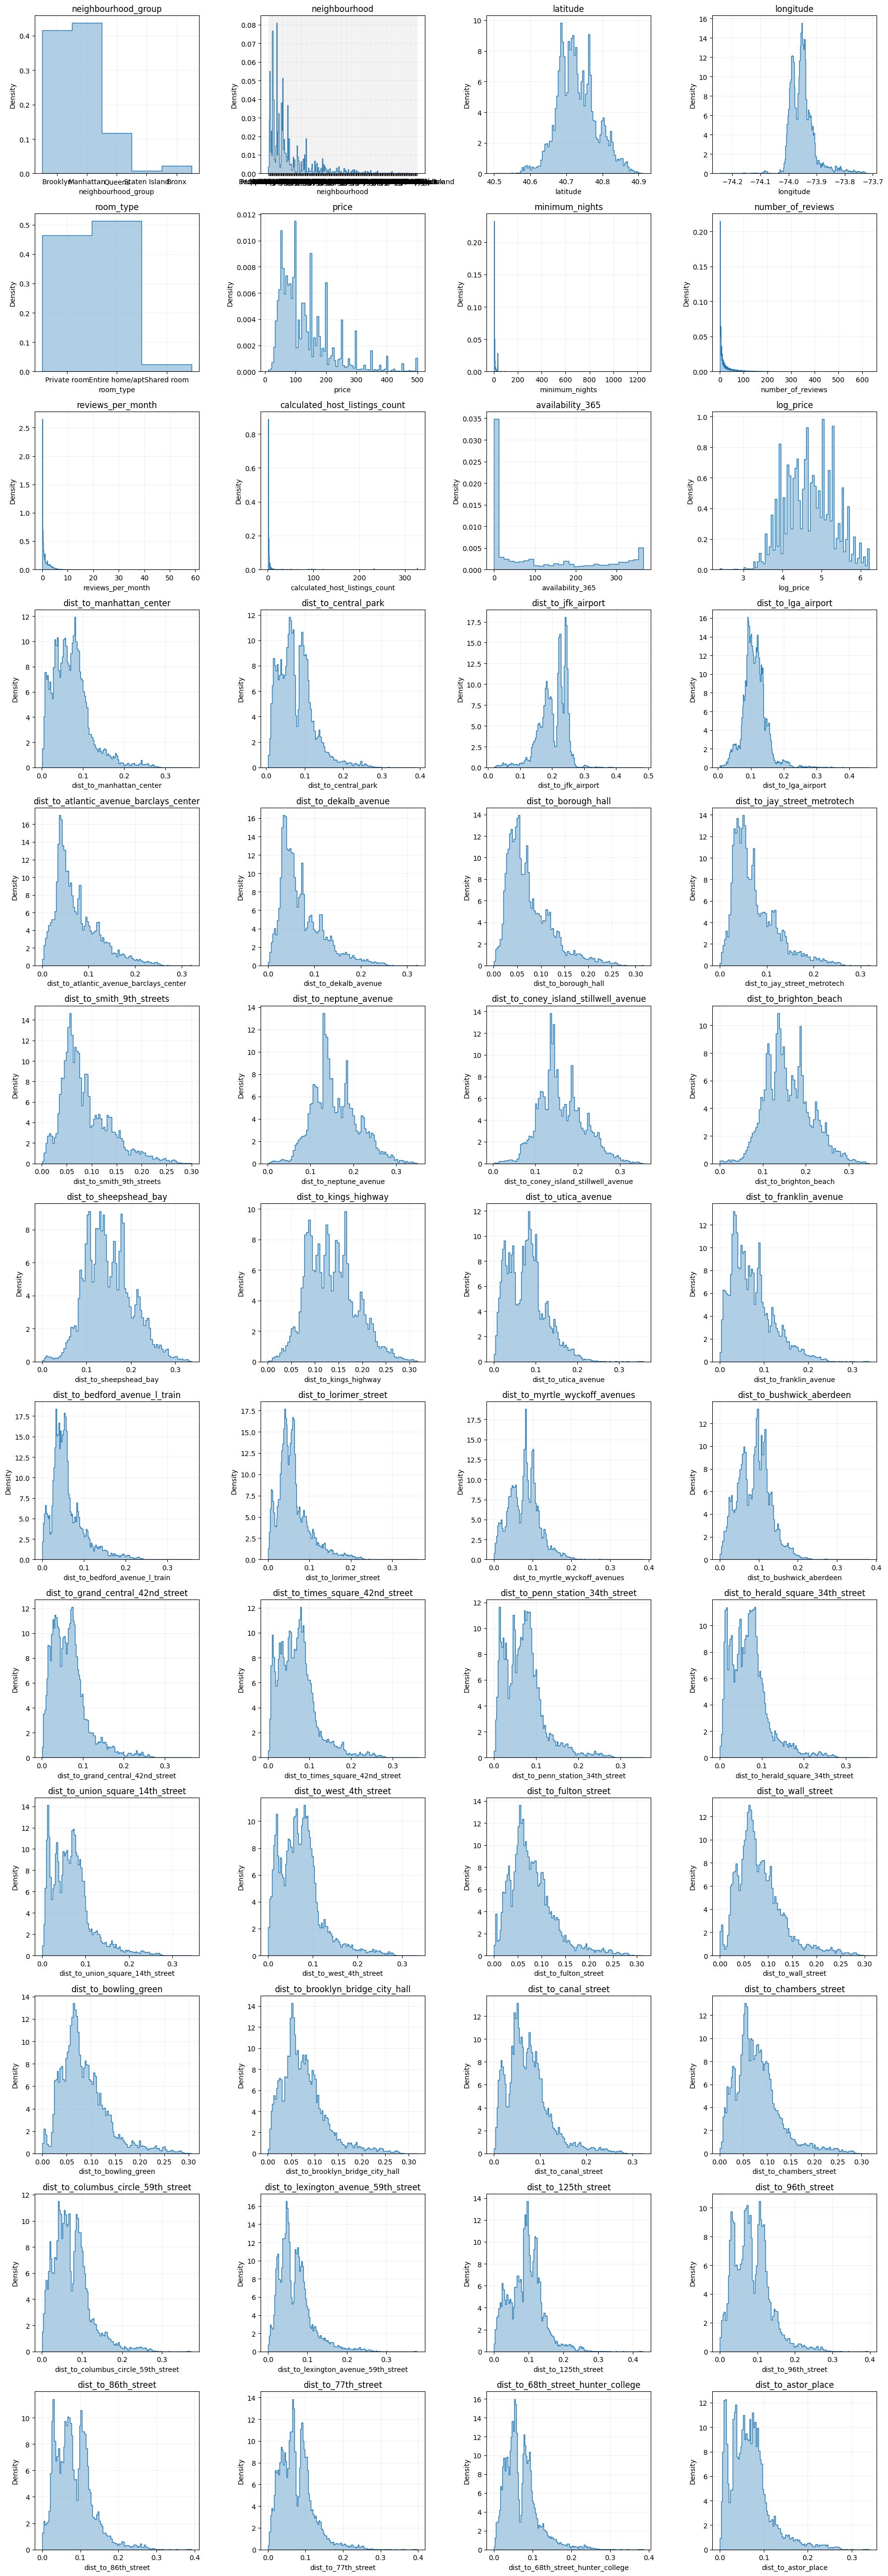

In [203]:
print_plots(df2)

## Определяем фичи и таргет

In [ ]:
features = [
    "neighbourhood_group",
    "room_type",
    "latitude", 
    "longitude",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365",
]

numeric_features = [
    "latitude",
    "longitude",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365",
]

features_with_dist = [
    "neighbourhood_group",
    "room_type",
    "latitude", 
    "longitude",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365",
]

for name, (lat_poi, lon_poi) in points_of_interest.items():
    features_with_dist.append(f"dist_to_{name}")

numeric_features_with_dist = [
    "latitude",
    "longitude",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365",
]

for name, (lat_poi, lon_poi) in points_of_interest.items():
    numeric_features_with_dist.append(f"dist_to_{name}")


categorical_features = ["neighbourhood_group", "room_type"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)

preprocessor_with_distances = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features_with_dist),
    ]
)

# После нормализации показатели качество ухудшились
# from sklearn.preprocessing import StandardScaler
# preprocessor = ColumnTransformer(
#     transformers=[
#         ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
#         ("num", Pipeline([("scaler", StandardScaler())]), numeric_features),
#     ]
# )

## Начинаем обучать модели - Линейная регрессия

Model: RidgeCV
Df name:  ordinary
Alpha: 0.1
MAE: 45.89115403944749
RMSE: 67.00007410257548


<Figure size 1000x800 with 0 Axes>

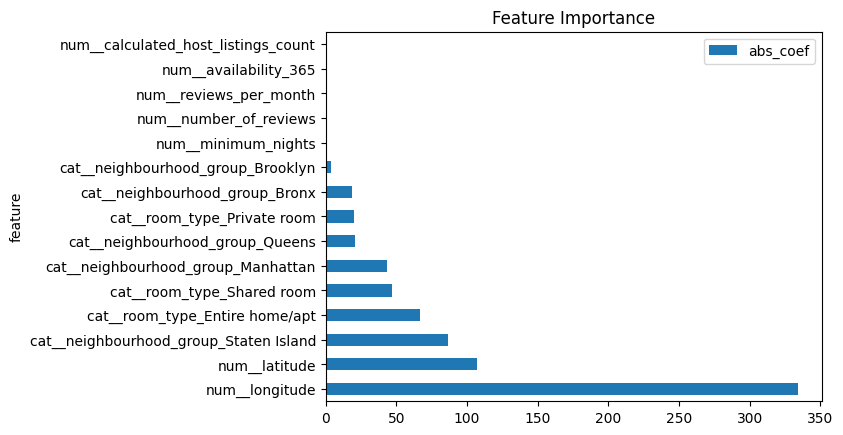

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [225]:
def train_RidgeCV(df, features, preprocessor, df_name):
    X = df[features]
    y = df["price"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    ridge_model = RidgeCV(
        alphas=[0.01, 0.1, 1.0, 10.0, 100.0],  # сетка для подбора alpha
        scoring="neg_mean_squared_error",      # или, например, "r2"
        cv=5
    )

    ridge_pipe = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", ridge_model),
        ]
    )

    pipe_info = ridge_pipe.fit(X_train, y_train)

    y_pred = ridge_pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))

    print("Model: RidgeCV")
    print("Df name: ", df_name)
    print("Alpha:", ridge_pipe.named_steps["model"].alpha_)
    print("MAE:", mae)
    print("RMSE:", rmse)

    # находим самые высокие коэффициенты
    ridge_pipe_coef_df = pd.DataFrame({
        "feature": ridge_pipe.named_steps["preprocess"].get_feature_names_out(),
        "coef": ridge_model.coef_
    })
    ridge_pipe_coef_df['abs_coef'] = ridge_pipe_coef_df['coef'].abs()
    ridge_pipe_coef_df = ridge_pipe_coef_df.sort_values("abs_coef", ascending=False)
    plt.figure(figsize=(10, 8))
    ridge_pipe_coef_df.head(20).plot(
        x="feature",
        y="abs_coef",
        kind="barh",
        title="Feature Importance"
    )
    plt.show()

    return pipe_info

train_RidgeCV(df, features, preprocessor, 'ordinary')

## С расстояниями до точек притяжения

Model: RidgeCV
Df name:  WITH_DISTANCES
Alpha: 0.01
MAE: 43.87041746522905
RMSE: 64.78611230540588


<Figure size 1000x800 with 0 Axes>

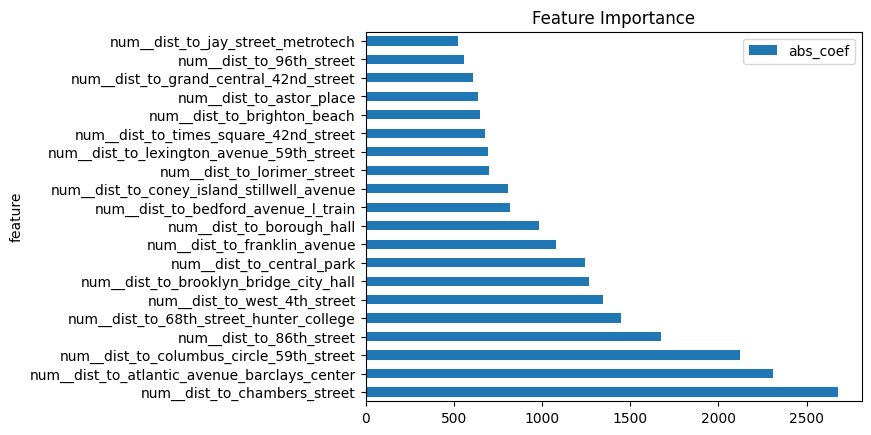

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [226]:
train_RidgeCV(df2, features_with_dist, preprocessor_with_distances, 'WITH_DISTANCES')

## Обучаем модель LassoCV

Model: LassoCV
Df name:  Ordinary
Alpha: 1.1316949640081777
MAE: 46.81410211972769
RMSE: 68.33749891626222


<Figure size 1000x800 with 0 Axes>

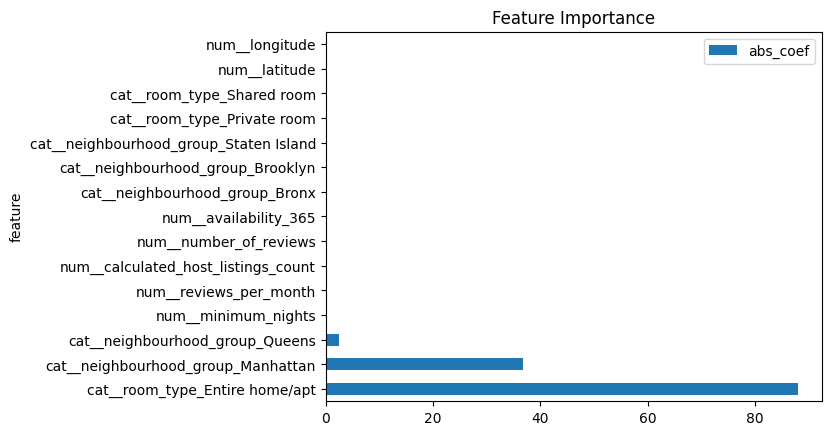

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [227]:

def train_LassoCV(df, features, preprocessor, df_name='Ordinary'):
    X = df[features]
    y = df["price"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    lasso_model = LassoCV()
    lasso_pipe = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", lasso_model),
        ]
    )

    pipe_info = lasso_pipe.fit(X_train, y_train)

    y_pred = lasso_pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))

    lasso_pipe_coef_df = pd.DataFrame({
        "feature": lasso_pipe.named_steps["preprocess"].get_feature_names_out(),
        "coef": lasso_model.coef_
    })

    print("Model: LassoCV")
    print("Df name: ", df_name)
    print("Alpha:", lasso_pipe.named_steps["model"].alpha_)
    print("MAE:", mae)
    print("RMSE:", rmse)

    lasso_pipe_coef_df['abs_coef'] = lasso_pipe_coef_df['coef'].abs()
    lasso_pipe_coef_df = lasso_pipe_coef_df.sort_values("abs_coef", ascending=False)
    plt.figure(figsize=(10, 8))
    lasso_pipe_coef_df.head(20).plot(
        x="feature",
        y="abs_coef",
        kind="barh",
        title="Feature Importance"
    )
    plt.show()

    return pipe_info

train_LassoCV(df, features, preprocessor)

## С расстояниями до точек притяжения

Model: LassoCV
Df name:  WITH DISTANCE
Alpha: 1.1316949640081748
MAE: 46.81410211972769
RMSE: 68.33749891626222


<Figure size 1000x800 with 0 Axes>

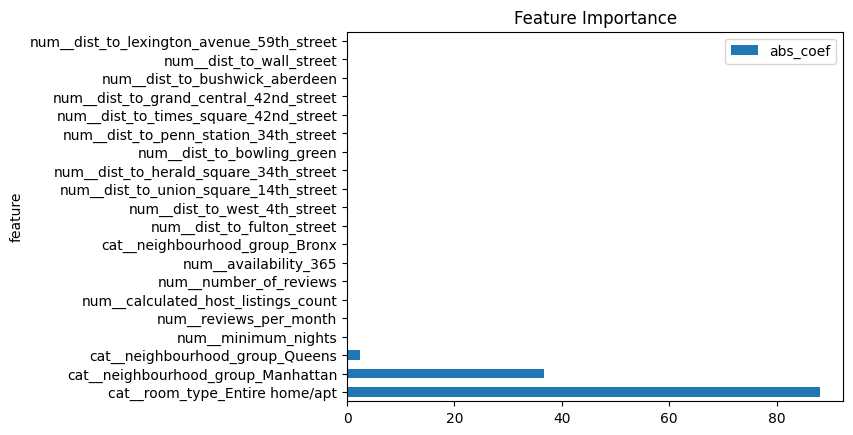

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [228]:
train_LassoCV(df2, features_with_dist, preprocessor_with_distances, 'WITH DISTANCE')

## Обучаем модель ElasticNetCV

Model: ElasticNetCV
DF name:  Ordinary
Alpha: 2.2633899280163554
MAE: 57.477456888453574
RMSE: 78.5447190654177


<Figure size 1000x800 with 0 Axes>

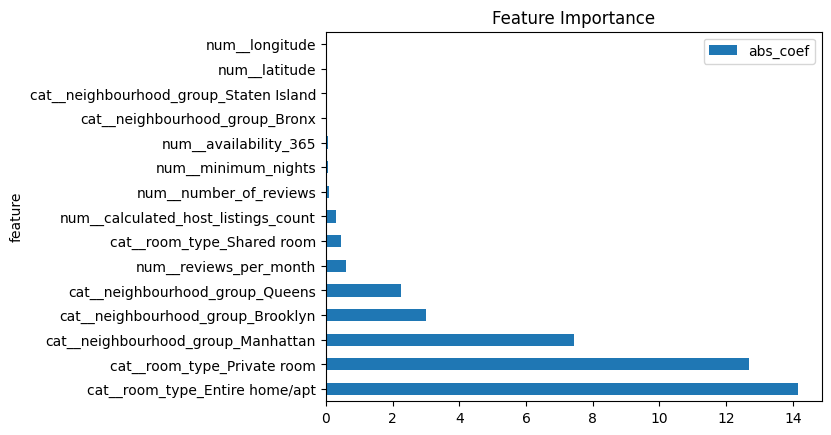

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [229]:
def train_ElasticNetCV(df, features, preprocessor, df_name='Ordinary'):
    X = df[features]
    y = df["price"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    elastic_net_model = ElasticNetCV()

    elastic_net_pipe = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", elastic_net_model),
        ]
    )

    pipe_info = elastic_net_pipe.fit(X_train, y_train)

    y_pred = elastic_net_pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))

    print("Model: ElasticNetCV")
    print("DF name: ", df_name)
    print("Alpha:", elastic_net_pipe.named_steps["model"].alpha_)
    print("MAE:", mae)
    print("RMSE:", rmse)

    elastic_net_pipe_coef_df = pd.DataFrame({
        "feature": elastic_net_pipe.named_steps["preprocess"].get_feature_names_out(),
        "coef": elastic_net_model.coef_
    })

    elastic_net_pipe_coef_df['abs_coef'] = elastic_net_pipe_coef_df['coef'].abs()
    elastic_net_pipe_coef_df = elastic_net_pipe_coef_df.sort_values("abs_coef", ascending=False)
    plt.figure(figsize=(10, 8))
    elastic_net_pipe_coef_df.head(20).plot(
        x="feature",
        y="abs_coef",
        kind="barh",
        title="Feature Importance"
    )
    plt.show()

    return pipe_info

train_ElasticNetCV(df, features, preprocessor)

## С расстояниями до точек притяжения

Model: ElasticNetCV
DF name:  WITH DISTANCES
Alpha: 2.2633899280163496
MAE: 57.47135661691923
RMSE: 78.53793252279391


<Figure size 1000x800 with 0 Axes>

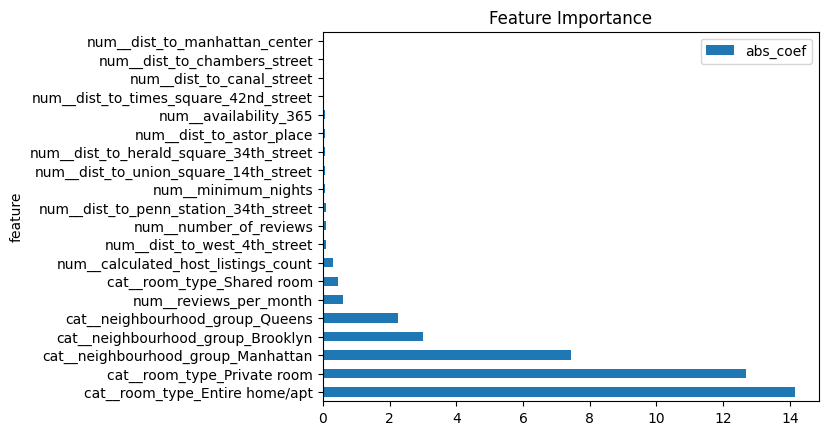

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [230]:
train_ElasticNetCV(df2, features_with_dist, preprocessor_with_distances, 'WITH DISTANCES')

## Обучаем модель RandomForestRegressor

Model: ElasticNetCV
DF name:  Ordinary
RF MAE: 39.83467294587147
RF RMSE: 60.13723989818


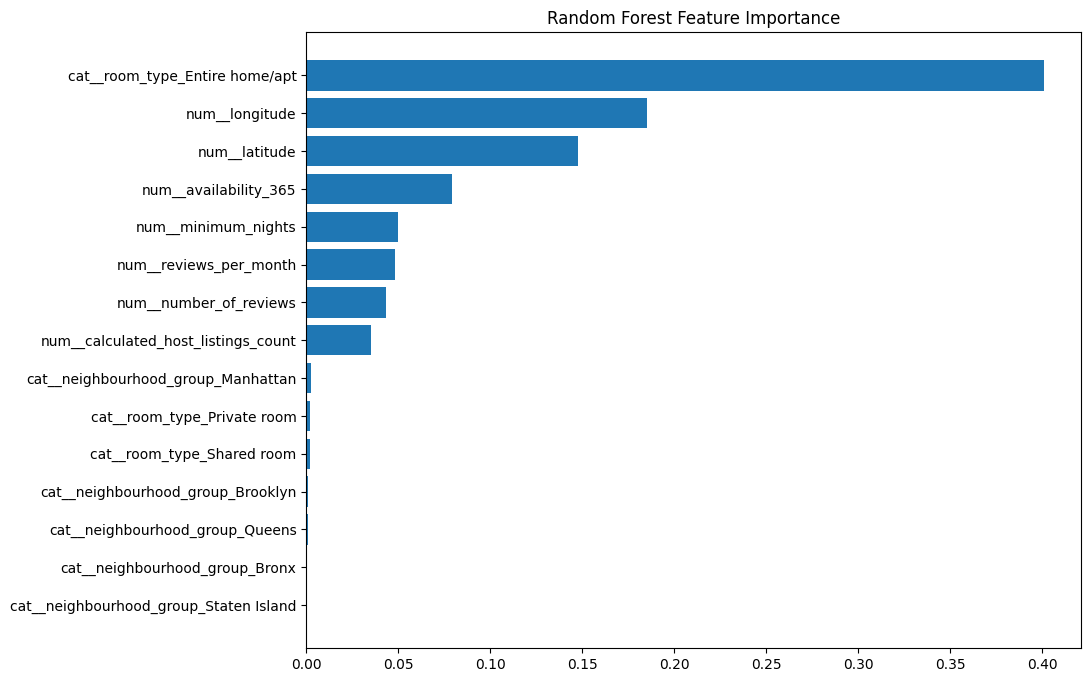

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [231]:

def traint_RandomForestRegressor(df, features, preprocessor, df_name='Ordinary'):
    X = df[features]
    y = df["price"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=14,
        random_state=42,
        n_jobs=-1
    )

    rf_pipe = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", rf_model),
        ]
    )

    pipe_info = rf_pipe.fit(X_train, y_train)

    y_pred_rf = rf_pipe.predict(X_test)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    rmse_rf = math.sqrt(mean_squared_error(y_test, y_pred_rf))

    print("Model: ElasticNetCV")
    print("DF name: ", df_name)
    print("RF MAE:", mae_rf)
    print("RF RMSE:", rmse_rf)

    rf = rf_pipe.named_steps["model"]
    feature_names = rf_pipe.named_steps["preprocess"].get_feature_names_out()

    imp_df = pd.DataFrame({
        "feature": feature_names,
        "importance": rf.feature_importances_
    }).sort_values("importance", ascending=False)

    plt.figure(figsize=(10, 8))
    plt.barh(imp_df["feature"].head(20), imp_df["importance"].head(20))
    plt.gca().invert_yaxis()
    plt.title("Random Forest Feature Importance")
    plt.show()

    return pipe_info

traint_RandomForestRegressor(df, features, preprocessor)

## С расстояниями до точек притяжения

Model: ElasticNetCV
DF name:  WITH DISTANCES
RF MAE: 39.931754146887656
RF RMSE: 60.233849851422896


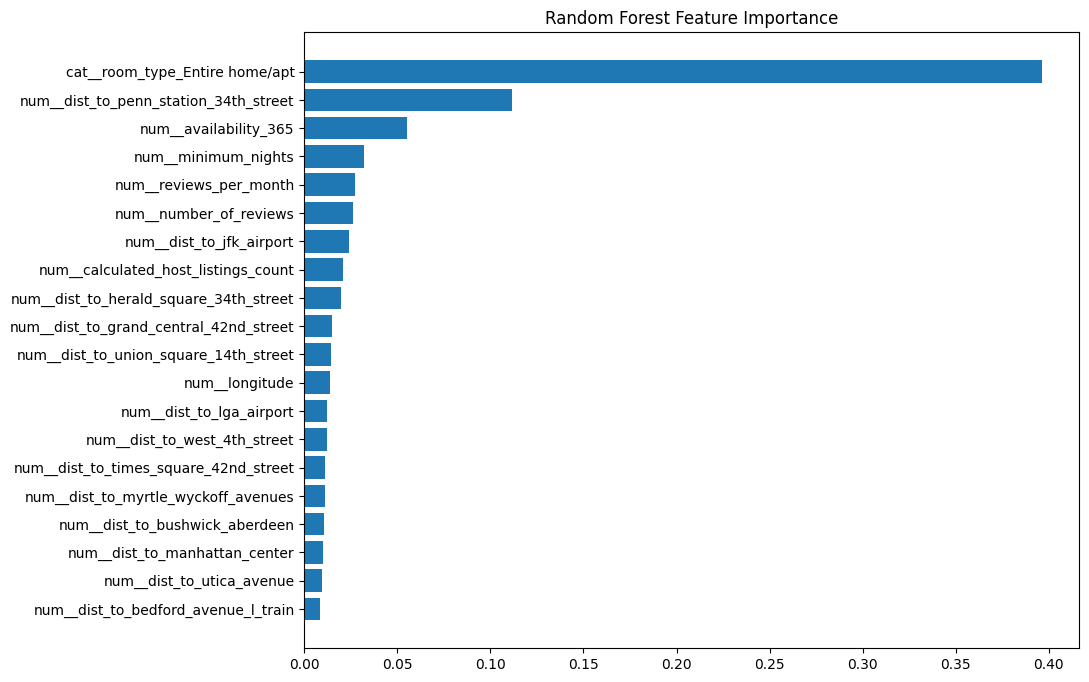

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [232]:
traint_RandomForestRegressor(df2, features_with_dist, preprocessor_with_distances, 'WITH DISTANCES')

## Вывод

В результате исследований не удалось выявить явную зависимость между ценой аренды жилья и расстоянием до точек притяжения. Модели линейной регрессии, LassoCV, ElasticNetCV и RandomForestRegressor показали низкие резальтаты , что свидетельствует о слабой предсказательной способности данных признаков. При средней цене 152 и медианной цене 100, модели дают ошибку в 39 в лучшем случае, что составляет значительную долю от самой цены. Это говорит о том, что расстояние до точек притяжения не является ключевым фактором, влияющим на стоимость аренды жилья в данном наборе данных. Для более точного предсказания цен необходимо рассмотреть дополнительные факторы, такие как характеристики жилья, качество ремонта. Если ввести категрии жилья по его качеству. Премиум, средний, эконом и т.д. Возможно это даст лучший результат.